# Virgo Exercise

The aim of the exercise is to prepare a ML tool which is able to compress and clean as much as possible a gwf data 

In this exercise you will:

- explore the content of an open dataset from IGWN containing the strain in function of time
- try to plot quantities and understand what can be used
- train various (?) network type in order to perform the job, and test their abilities; this can be done at various complexity levels


For an introduction on what GW and interferometers are please refer to https://confluence.infn.it/display/MLINFN/7.+Virgo+Autoencoder+tutorial

For a brief vocabulary see https://labcit.ligo.caltech.edu/~ll_news/0607a_news/LIGO_Vocabulary.htm

**IGWN** stands for International Gravitational-Wave Observatory Network, it is a comunity made by three collaborations: LIGO VIRGO and KAGRA 

**Strain** is the instrument’s ability to detect a space change within an arm in comparison to the total space (length) of the arm

**GWF** stands for Gravitational Wave File and is the format IGWN used to store (not only!) interferometer strain

All data we will use in this tutorial is freely accessibile and published in **GWOSC** (https://www.gw-openscience.org/about/). GWOSC, The Gravitational Wave Open Science Center, provides data from gravitational-wave observatories, along with tutorials and software tools. You could find there many information if you are interested

To begin we will import all functions needed!

To help in reading IGWN files we will used a python package called **gwdama**

*gwdama* (https://pypi.org/project/gwdama/) aims at providing a unified and easy to use interface to access Gravitational Wave (GW) data and output some well organised datasets, ready to be used for Machine Learning projects or Data Analysis purposes (source properties, noise studies, etc.)

In [1]:
#maybe needed, do it only if you have an error like "No module named 'gwdama'"" below
!pip install gwdama

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 46 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 53.2 MB/s eta 0:00:01
     |████████████████████████████████| 27.3 MB 210 kB/s  eta 0:00:01     |██████████████▎                 | 12.2 MB 34.8 MB/s eta 0:00:01     |████████████████                | 13.6 MB 34.8 MB/s eta 0:00:01     |██████████████████              | 15.3 MB 34.8 MB/s eta 0:00:01     |████████████████████████        | 20.5 MB 34.8 MB/s 

In [2]:
from gwdama.io import GwDataManager
import numpy as np
from scipy.stats import norm
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

Accessible data is ordered by gps time and run type (Observing Calibration etc..). Observing run, generally called O with a number to distinguish between many of them (for example **O3**), are our scientific and acquisition runs

**gps time** is a timestamp relative to an arbitrarly event, internally we use tools to convert to usual time

At https://www.gw-openscience.org/events/ you could find a list of events with their gps time and a brief description of the results

Let's get data between two gps 1186746568 and 1186746628 from GWOSC and call it "**online** dataset"

In [3]:
event_gps = 1186746618  
dama = GwDataManager()
dama.read_gwdata(event_gps - 50, event_gps +10, ifo='L1',data_source="gwosc-online",dts_key='online')

In [4]:
print(dama)

mydama:
  └── online

  Attributes:
     dama_name : mydama
    time_stamp : 21-04-26_11h40m41s



data acquisition is 21-04-21_10h50m25s.
To acquire some confidence with data we will start with a plot

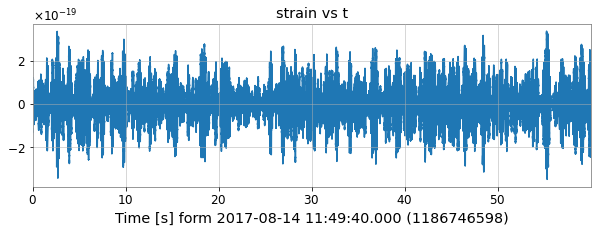

In [189]:
online=dama['online']

# time vs strain
# to make plot more nice add some properties, they will be addedd to the figure
online.attrs['t0'] = 1186746598
online.attrs['sample_rate'] = 4096   # Unit Hz
online.attrs['unit'] = ""
online.attrs['channel'] = "strain vs t"

online.plot()

**Note**: the timestamp is different because internally in the IGWN we use a different convention

**Exercise**: read multiple files and plot them with a single for loop

As a pretest to show some functions in gwdama, we will make an histogram of data and fit with a gaussian

**norm** is a class of scipy to work with a normal distribution (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). In this case we will use the fit method to estimate meand and standard deviation of the input signal. If a **gw** is not present than we can assume for the scope of this exercise that the signal is normal distribute (which is not in real life!) 

In [6]:
myplot = online.hist()
mu, std = norm.fit(online.data)

Customize the plot, adding the fitted gaussian and a legend

**gca** method gets the current Axes, creating one if necessary

**get_xlim** return min and max value on the x axis

**linspace** return evenly spaced number in an interval

**pdf** return a probability density function (see norm before)

**plot** plot x,y data. 'r--' is used to control the line style (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) 

**legend** add a legend to the plot

**show** is used to show the plot

In [7]:
ax = myplot.gca()
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'r--', linewidth=1, label='Gaussian fit')
ax.legend()

myplot.reshow()                    # New method to re-show closed figures

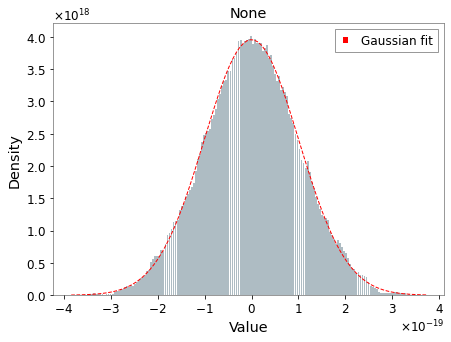

In [8]:
myplot

Create a **PSD** with sample rate 4096 Hz

**Note**: Power Spectral Density (PSD) is the measure of signal's power content versus frequency. A PSD is typically used to characterize broadband random signals

In [171]:
fs = 4096
online.attrs['sample_rate'] = fs
online.psd(2,1)

<HDF5 dataset "online_psd": shape (4097,), type "|V16">

In [176]:
print(dama)

mydama:
  ├── online
  ├── online_psd
  ├── online_whiten
  ├── online_whiten_r10
  └── random_n

  Attributes:
     dama_name : mydama
    time_stamp : 21-04-26_11h40m41s



The psd is added to our dataset with name_psd

Now plot the PSD

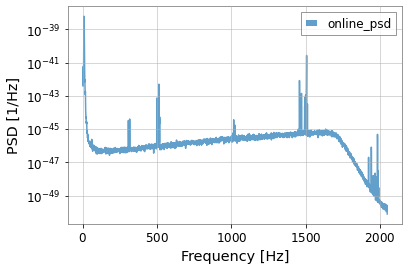

In [179]:
online_psd=dama['online_psd']
fig, ax = plt.subplots()
ax.semilogy('freq', 'PSD', data=online_psd, alpha=.7, label='online_psd')

ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [1/Hz]')
plt.show()
fig


We generally work with signal normalize to its spectral density

A **whitned** signal is a normalized signal to its spectral density. To compute it you should get in the freq domain, divide it by the square roots of the power spectral density and return to time domain

For convenience gwdama provides a simple function that whiten the signal: output=whiten(input, input_psd, freq)
or dama['name'].whiten() and the output will be dama['name_whiten']

In [35]:
import gwdama.preprocessing as pre
dama['online'].whiten()
#online_cleaned = pre.whiten(dama['online'].data, dama['online_psd'].data, 1./500)

<HDF5 dataset "online_whiten": shape (245760,), type "<f8">

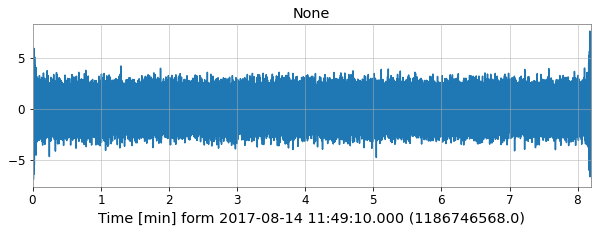

In [149]:
# let's plot it
dama['online_whiten'].plot()

This data is sampled at 4096 Hz, but our interferometers acts like a pass band signal from a frequency ~ between 20-400Hz so it could be usefull to resample the data in order to work with lighter files and remove some noise

**decimate_recursive** resamples an input signal keeping only 1 elem every n

In [36]:
print(dama)

mydama:
  ├── online
  ├── online_psd
  ├── online_whiten
  └── random_n

  Attributes:
     dama_name : mydama
    time_stamp : 21-04-26_11h40m41s



In [53]:
dama['online_whiten'].resample(10)

<HDF5 dataset "online_whiten_r10": shape (4916,), type "<f8">

In [54]:
print(dama)
# You can delete an entry with
#del dama["online_whiten_r10"]

mydama:
  ├── online
  ├── online_psd
  ├── online_whiten
  ├── online_whiten_r10
  └── random_n

  Attributes:
     dama_name : mydama
    time_stamp : 21-04-26_11h40m41s



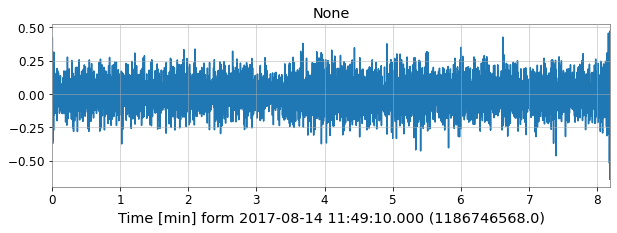

In [151]:
# let's plot it
dama['online_whiten_r10'].plot()

if you want to get more information on data and the cleaning process here a usefull link https://github.com/losc-tutorial/Data_Guide/blob/master/Guide_Notebook.ipynb

Once data is ready we can try to encode with an **autoencoder**

[from wiki]: An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learned, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name

some examples of autoencoders in keras at https://blog.keras.io/building-autoencoders-in-keras.html

The idea is to downsampling and resampling to original dimension searching for an optimum parameters that makes filtered signal more similar to original one. The downsampled signal will retain all needed information but with a reduction of size

To make our statement more concise we will summary some ideas on Artificial Neural Networks and Deep Learning

## Artificial Neural networks 

**Artificial neural networks (ANNs)** are computing systems vaguely inspired by the biological neural networks that constitute animal brains.

An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called edges. Neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold. Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple time and along different paths

Artificial networks could be build by many layers, each one connected to each others. There are amny types of networks. For example:

A **feedforward neural network** is an artificial neural network wherein connections between nodes do not form a cycle, layers are connected starting from the top (input) to the bottom (output) and the activation flows from top to the end exclusively

A **recurrent neural network (RNN)** is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. Typically part of output of one layer is feed as input to the same layer at a different time

[https://en.wikipedia.org/wiki/Artificial_neural_network]

## Layers

**Layers** are group of nodes that mimic some concepts. Each node inside the layer shares same input and output and the same activation function

## Activation function

The **activation function** of a node defines the output of that node given an input or set of inputs. Experience shows that only nonlinear activation functions allow networks to compute nontrivial problems using only small number of nodes

- **rectifier or ReLU** activation function is an activation function defined as the positive part of its argument

- **Sigmoid** activation function is an activation function which applies a sigmoid to the input. The assumption here is that we are interested in intermediate value of input, so we treat them in a liner way, greater values in modulo are not so important because are extreme and show fewer variation

[ https://en.wikipedia.org/wiki/Activation_function ]

## Loss function
Loss is nothing but a prediction error of Neural Network. And the method to calculate the loss is called Loss Function

## Optimizer

The **optimizer** is used to explorer the parameters space searching which value correspond to a minimum value of the loss function

## Learning 

**Supervised learning** is the machine learning task of learning a function that maps an input to an output based on example input-output pairs

**Unsupervised learning** is the task of learning a function that maps an input to an output based on some cost function

## Overfitting

Overfitting is a modeling error in statistics that occurs when a function is too closely aligned to a limited set of data points. Overfitting the model generally takes the form of making an overly complex model to explain idiosyncrasies in the data under study

## Regularization

Regularization in machine learning is the process of regularizing the parameters that constrain, regularizes, or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, reducing the risk of Overfitting

## Restatement of the task

An autoencoder has an input layer, an output layer and one or more hidden layers connecting them. The output layer has the same number of units as the input layer. Its purpose is to reconstruct its own inputs. Therefore, autoencoders are unsupervised learning models. We want our autoencoder to efficient codings using unsupervised learning

**Question**: Could an autoencoder have in total only a single layer? Two layers? Three?

**Remark**:The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. A metric is used to judge the performance of your model!

We will use keras ( https://keras.io/ )
"Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides."

Some usefull info:

- https://blog.keras.io/building-autoencoders-in-keras.html

- https://keras.io/api/models/

In the following we will use a slightly different approch from usual, instead of using a single command, we use sklearn as interface to call other functions. The idea is to learn to wrap Keras models for use in scikit-learn and how to use grid search. "GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps *to loop through predefined hyperparameters* and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters" 

Please **Remember**: Keras is a high-level API built on Tensorflow. Scikit Learn is a general machine learning library built on top of NumPy

[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html ] 

[https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ ]

Some layers used in keras:

- **Dense** layer makes output=activation(dot(input, kernel) + bias) where kernel is the matrix of parameters and activation is the activation function. Each node is fed by the whole input! 

- **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged

## Simple example

A skeleton will take input, import relevant functions, define a model, optimize it and test it

Let's start!

In [58]:
# input
# we will split our data in chunk of n elements and we will feeds our network with all these chunks
n_features = 100 # is the size of a single chunk of data

# add a normal dataset to dama
dama.create_dataset('random_n', data=np.random.normal(0, 1, (10000,)))

# access its data and store in variable input_data
input_data = dama['random_n'].data

# split data in chunks of 100 element each one and stack each chunk vertically
chunks = np.stack(np.split(input_data,100))
chunks.shape

(100, 100)

In [19]:
import math

from keras import optimizers
from keras.optimizers import Nadam

from keras import regularizers

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, TimeDistributed

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

import joblib

In [42]:
# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model = Sequential()
    model.add(Dense(n_features, activation='sigmoid', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model.add(Dense(n_features, activation='relu', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model

We had defined a function (with four parameters!) that build a very minimalistic model

**Sequential** initialize the model

**add** method is used to add layers to your model

**compile** method id used to configure the model for training https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

some reference to its parameters:
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric

You could get usefull debugging message with **model.summary()**

In [43]:
# machine learning
# epochs is used for recurrent networks, we don't need them so we set to 1
# batch_size is the number of input chunks
mlp = KerasRegressor(build_fn=baseline_model, epochs=1, batch_size=n_features, verbose=0)

**KerasRegressor** is a wrapper to use keras from sklearn. It takes as parameters, your function model, epochs, batch size. See for example https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

The **batch size** is a hyperparameter that defines the number of samples to work through before updating the internal model parameters

The number of **epochs** is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. See for example https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [44]:
# space of parameters used when call our model
param_distr = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])

param_distr is a dictionary of parameters to try, we will explore on all combinations
**Query**: How many combinations will have in a general case? In this case?

In [45]:
# build our model all together
grid_search = GridSearchCV(estimator=mlp, param_grid=param_distr, cv=3)

**GridSearchCV** Exhaustive search over specified parameter values for an estimator. So we are trying all combinations! https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In particular: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit

X: array-like of shape (n_samples, n_features)

In [47]:
# fit it
# vay all nodes based on param_distr to make output "near" to input. Near here mean output of a distance function 'mse' 
grid_search.fit(chunks, chunks)

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f0c24392a58>,
             param_grid={'bias1': [1e-09], 'bias2': [1e-09], 'ker1': [1e-09],
                         'ker2': [1e-09]})

In [48]:
# get some info
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means  = grid_search.cv_results_['mean_test_score']
stds   = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

Best: -1.127155 using {'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}


**Question**: Is output data only positive? why?

## Exercise 1: Alter input and model to have in output value between a different range

Redo all steps but in the model function use a different activation function

In [92]:
# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model1(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model1 = Sequential()
    model1.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model1.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model1.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model1


mlp1 = KerasRegressor(build_fn=baseline_model1, epochs=1, batch_size=n_features, verbose=0)
param_distr1 = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
grid_search1 = GridSearchCV(estimator=mlp1, param_grid=param_distr1, cv=3)
grid_search1.fit(chunks, chunks)
print("Best: %f using %s" % (grid_search1.best_score_, grid_search.best_params_))
means  = grid_search1.cv_results_['mean_test_score']
stds   = grid_search1.cv_results_['std_test_score']
params = grid_search1.cv_results_['params']

Best: -0.265259 using {'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}


## Exercise 2: example with real data

We need to follow exactly what we did before but using our gw data insetad of our simulated data

Recall that to get data from dama you could use "dama['random_n'].data" 

In real life before start we will have to decide what will be
- our chunk size
- our metric

using frequency and other values as starting point

We can however start with an (nearly!) arbitrary value and see what will happen



In [93]:
print(dama['online_whiten_r10'])
input_data=np.array(dama['online_whiten_r10'].data)
input_data.shape

<HDF5 dataset "online_whiten_r10": shape (4916,), type "<f8">


(4916,)

get a number of point mutiple of 100

In [78]:
input_data[0:4900].shape

(4900,)

In [90]:
chunks = np.stack(np.split(input_data[0:4900],100))
chunks.shape

(100, 49)

as already said, we have an array-like of shape (n_samples, n_features)
so here we have 49 features in 100 samples

We can now proceed as usual

In [106]:
n_features=49

# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model2(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model2 = Sequential()
    model2.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model2.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model2.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model2


mlp2 = KerasRegressor(build_fn=baseline_model2, epochs=100, batch_size=10, verbose=0)
param_distr2 = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
grid_search2 = GridSearchCV(estimator=mlp2, param_grid=param_distr2, cv=3)
grid_search2.fit(chunks, chunks)
print("Best: %f using %s" % (grid_search2.best_score_, grid_search2.best_params_))
means  = grid_search2.cv_results_['mean_test_score']
stds   = grid_search2.cv_results_['std_test_score']
params = grid_search2.cv_results_['params']

Best: -0.260025 using {'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}


**Note**: Could you alter code to have 49 elems(samples) of 100 features each one?

## Exercise 3: Alter model, adding a dropout layer and a new dense layer

That's where we get our compression! we are asking to our model please try to be as similar as possible to the input signal with less variables. The number of variables in this case is the number of neuron in the droput layer

Try to build a model that half the variable.  Suggestion pass 0.5 to droput and set size according to dense layer

In [148]:
n_features=49
dropout=0.1

# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model3(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model3 = Sequential()
    
    model3.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dropout(dropout))
    model3.add(Dense(int(n_features/2), activation='relu', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dropout(dropout))
    model3.add(Dense(int(n_features/4), activation='relu', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dropout(dropout))

    model3.add(Dense(int(n_features/4), activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dense(int(n_features/2), activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    
    model3.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model3


mlp3 = KerasRegressor(build_fn=baseline_model3, epochs=1, batch_size=100, verbose=0)
param_distr3 = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
grid_search3 = GridSearchCV(estimator=mlp3, param_grid=param_distr3, cv=3)
grid_search3.fit(chunks, chunks)
print("Best: %f using %s" % (grid_search3.best_score_, grid_search3.best_params_))
means  = grid_search3.cv_results_['mean_test_score']
stds   = grid_search3.cv_results_['std_test_score']
params = grid_search3.cv_results_['params']

Best: -0.273984 using {'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}


We altered number of neurons, is metric better or worse compare to other exercise? was expected?

## Exercise 4: Tune parameters

**Add to param_distr both Batch size and Epochs, retrain and take best values**

...same model as before...

batch_size = [10, 20, 40, 60, 80, 100]

epochs = [10, 50, 100]

param_distr = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9], batch_size=batch_size, epochs=epochs )

grid_search4 = GridSearchCV(estimator=mlp4, param_grid=param_distr4, cv=3)

grid_result=grid_search4.fit(chunks, chunks)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):

    print("%f (%f) with: %r" % (mean, stdev, param))

**Same as before but optime optimizer**

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(optimizer=optimizer)

**With this system you could optimize any hyperparameters...but it works only for local minimum point. No one can guarantee that a minimum for non optimal parameters exists!**

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Exercise 4 (long): Build a complex model which takes as input signal at different freq

## Exercise 5: Plot output data and compare with input signal

We already have an autoencoder. From the output of GridSearchCV we got best parameters. Now how we could encode-decode a signal and compare with the original one?

GridSearchCV.predict(data) return an encoded-decoded signal, we could simply make a diff or plot original signal with autoencoded one

In [111]:
grid_search2.predict(chunks).shape

(100, 49)

There are many ways to get the encoded signal, for example re-train the model, using as parameterets the ones found by GridSearchCV. In this case :

Best: -0.280207 using **{'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}**

In [137]:
# rebuid a model
model=baseline_model3()
model.summary()
# fit it
model.fit(chunks,chunks)

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 49)                2450      
_________________________________________________________________
dropout_37 (Dropout)         (None, 49)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 24)                1200      
_________________________________________________________________
dropout_38 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_308 (Dense)            (None, 12)                300       
_________________________________________________________________
dropout_39 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_309 (Dense)            (None, 12)             

In [147]:
# build a model of only encoding layers
encoder = Sequential()

for el in range(1,7):
    encoder.add(model.layers[el])

encoded = encoder.predict(chunks)
print(encoded)
encoded.shape

[[0.48904893 0.50333536 0.4929569  ... 0.522956   0.49948746
  0.50268465]
 [0.4896837  0.4858967  0.49586704 ... 0.5027559  0.48362204
  0.510903  ]
 [0.5102337  0.49362165 0.49392977 ... 0.49080157 0.51808566
  0.49943066]
 ...
 [0.48470744 0.4942796  0.49743313 ... 0.5092964  0.49551228
  0.5036354 ]
 [0.4693479  0.4908574  0.5076007  ... 0.5261267  0.4926661
  0.522329  ]
 [0.4889197  0.48772776 0.4801538  ... 0.5060688  0.4805267
  0.4899119 ]]


(100, 12)

**Note**: Comrpession at work! 12 Features instead of 49

You can access weight using

**model.get_weights()[0]** to get all values

**model.layers[0].get_weights()[0]** to get values of a single layer

In [146]:
# for example
model.get_weights()[0] 
model.layers[0].get_weights()[0]

array([[ 0.2274417 , -0.19220123, -0.20534934, ...,
         0.11381795,  0.0450944 ,  0.04863816],
       [ 0.08812055,  0.16506046,  0.09408816, ...,
         0.13019182, -0.23757611, -0.17694919],
       [-0.0763713 , -0.03519882, -0.08814728, ...,
        -0.08351736, -0.15157472,  0.16284977],
       ...,
       [ 0.18159573,  0.23673372, -0.18329293, ...,
         0.09571739, -0.0400843 , -0.05365768],
       [-0.22071177,  0.21787955, -0.22288378, ...,
        -0.23995796, -0.1476485 ,  0.22771451],
       [-0.05796139, -0.09458324, -0.02477234, ...,
         0.17192806, -0.19338365,  0.04908046]], dtype=float32)

## Exercise 6: Save output files and compute their size and their entropy

In [ ]:
# to save our model
model.save("test.h5")
# to save our encoded file
# don't forget to delete our useness item before saving to disk
dama.write_gwdama('outputfile')